# **CS 1810 Homework 1**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 1, 3, and 4 on Homework 1. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**

In [1]:
# Loading data
import numpy as np
import matplotlib.pyplot as plt

train_data = np.genfromtxt("data/earth_temperature_sampled_train.csv", delimiter = ',')
year_train = train_data[:, 0] / 1000
temp_train = train_data[:, 1]
test_data = np.genfromtxt("data/earth_temperature_sampled_test.csv", delimiter = ',')
year_test = test_data[:, 0] / 1000
temp_test = test_data[:, 1]

# Problem 1

## Problem 1 Subpart 1(a)

In [2]:
def predict_knn(x_new, k, x_train, y_train):
    """
    Returns predictions for the values in x_test, using KNN predictor with the specified k.

    :param x_new: a numpy array of x_values on which to do prediction. Shape is (n,)
    :param k: number of nearest neighbors to consider
    :param x_train: x coordinates of training dataset
    :param y_train: y coordinates of training dataset

    :return: if x_new = [x_1, x_2, ...], then return [f(x_1), f(x_2), ...]
             where f is the kNN with specified parameters and training set
    """

    # Compute distances, shape is (n, m) where n is the number of test points and m is the number of training points
    dists = np.abs(x_train.reshape(1,-1) - x_new.reshape(-1,1))
    # Argsort the rows
    ix = dists.argsort(axis = 1)
    ix = ix[:, :k] # take only the k smallest distances
    y = y_train[ix]

    # sum each row
    return np.mean(y, axis = 1)

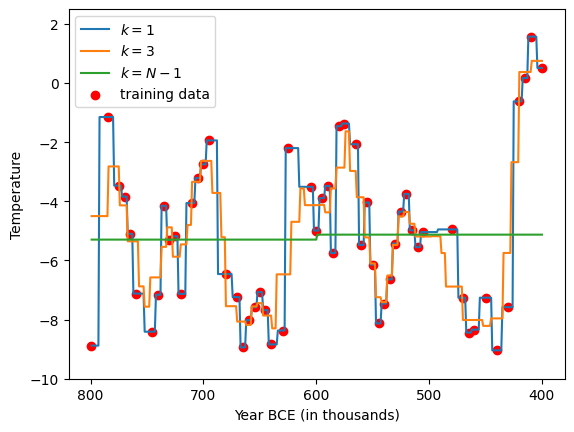

In [3]:
# plot functions
N = year_train.shape[0]
x_array = np.arange(400, 800, 1)
plt.plot(x_array, predict_knn(x_array, 1, year_train, temp_train), label = "$k = 1$")
plt.plot(x_array, predict_knn(x_array, 3, year_train, temp_train), label = "$k = 3$")
plt.plot(x_array, predict_knn(x_array, N - 1, year_train, temp_train), label = "$k = N - 1$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")

plt.legend()
plt.xticks(np.arange(400, 900, 100))
plt.ylim([-10,2.5])

plt.gca().invert_xaxis()
# save figure to img_output directory
plt.savefig("img_output/p1.1a.png", bbox_inches = "tight")
plt.show()

## Problem 1 Subpart 1(b)

In [8]:
def model_mse(predictions, true):
    """
    Calculate the MSE for the given model predictions, with respect to the true values

    :param predictions: predictions given by the model
    :param true: corresponding true values
    :return: the mean squared error
    """
    mse = ((predictions - true) ** 2).mean()
    return mse

In [ ]:
for k in [1, 3, N - 1]:
    mse = model_mse(predict_knn(year_test, k, year_train, temp_train), temp_test)
    print(f"MSE for k={k}: {mse}")

MSE for k=1: 1.7406000000000004
MSE for k=3: 3.8907662222222212
MSE for k=56: 9.528571442602042


## Problem 1 Subpart 2(a)

In [11]:
def kernel_regressor(x_new, tau, x_train, y_train):
    """
    Run f_tau(x) with parameter tau on every entry of x_new.

    :param x_new: a numpy array of x_values on which to do prediction. Shape is (n,)
    :param float tau: lengthscale parameter
    :param y_train: the x coordinates of the training set
    :param y_train: the y coordinates of the training set
    :return: if x_new = [x_1, x_2, ...], then return [f(x_1), f(x_2), ...]
             where f is calculated wrt to the training data and tau
    """
    # Expand dimensions to calculate distances between all test and train points
    dists = (x_new[:, np.newaxis] - x_train)**2
    
    # Compute the Kernels (K_tau)
    # This represents the 'weight' each training point has for each test point
    K = np.exp(-dists / tau)
    
    # Compute the weighted average: sum(K * y) / sum(K)
    predictions = np.sum(K * y_train, axis=1) / np.sum(K, axis=1)
    
    return predictions

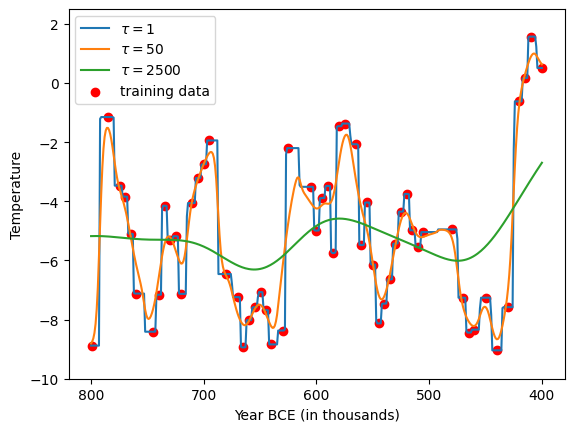

In [12]:
# Plot functions
x_array = np.arange(400, 800 + 1, 1)
for tau in [1, 50, 2500]:
    plt.plot(x_array, kernel_regressor(x_array, tau, year_train, temp_train), label = f"$\\tau = {tau}$")
plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.legend()
plt.xticks(np.arange(400, 800 + 100, 100))
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")
plt.ylim([-10,2.5])

plt.gca().invert_xaxis()
# save figure to img_output directory
plt.savefig("img_output/p1.2a.png", bbox_inches = "tight")
plt.show()

## Problem 1 Subpart 2(c)

In [13]:
# Compute the MSEs for different values of tau
def calculate_mse(tau, x_train, y_train, x_test, y_test):

    # Compute pairwise squared distances between test points and training points
    dists = (x_test[:, np.newaxis] - x_train)**2
    
    # Compute the kernels K_tau(x_n, x'_m)
    K = np.exp(-dists / tau)
    
    # Compute predictions for all test points
    # sum(K * y_train, axis=1) gives the numerator for each test point
    # sum(K, axis=1) gives the denominator for each test point
    predictions = np.sum(K * y_train, axis=1) / np.sum(K, axis=1)
    
    # Calculate MSE
    mse = np.mean((y_test - predictions)**2)
    return mse

# Evaluation
taus = [1, 50, 2500]
for t in taus:
    mse_val = calculate_mse(t, year_train, temp_train, year_test, temp_test)
    print(f"MSE for tau = {t:4d}: {mse_val:.4f}")

MSE for tau =    1: 1.9473
MSE for tau =   50: 1.8583
MSE for tau = 2500: 8.3339


# Problem 3

## Problem 3 Subpart 1

In [16]:
def exp_kernel(x,mu):
    return np.exp(-1/float(5)*np.power(x-mu,2))

def f_scale(X, part = "a"):
  if part == "a":
    X = X/181 # 181000
  elif part == "b":
    X = X/4e2 # 4e5
  elif part == "c":
    X = X/1.81 # 1810    
  elif part == "d":
    X = X/.181 # 181
  return X

# TODO: Complete this `make_basis` function according to the above
# specifications. The function should return the array `phi(X)`

def make_basis(X,part='a'):
  """
  Args:
    X: input of years (or any variable you want to turn into the appropriate basis) as
      ndarray with length `N`.
    part: one of `a`, `b`, `c`, `d` depending on the basis function.

  Returns:
    ndarray `phi(X)` of shape `(N,D)`. For each part the shapes of your
    training data `make_basis(years_train)` should be
      (a) 57x10, (b) 57x10, (c) 57x10, (d) 57x50.
  """
  
  ### DO NOT CHANGE THIS SECTION 
  ### it is to prevent numerical instability from taking the exponents of
  ### the years, as well as break symmetry when dealing with a Fourier basis.
  X = f_scale(X, part)
  ### end section

  N = len(X)
  # Determine the number of features (M) based on the part
  M = 49 if part == 'd' else 9
  
  # Initialize the design matrix with ones for the bias term (index 0)
  # Shape will be (N, M + 1)
  phi = np.ones((N, M + 1))

  # Part (a): Polynomial Basis phi_j(x) = f(x)^j
  if part == 'a':
      for j in range(1, M + 1):
          phi[:, j] = np.power(X, j)

  # Part (b): Radial Basis Function (RBF)
  elif part == 'b':
      for j in range(1, M + 1):
          mu_j = (j + 7) / 8.0
          phi[:, j] = exp_kernel(X, mu_j)

  # Part (c) and (d): Fourier Basis phi_j(x) = cos(f(x)/j)
  elif part == 'c' or part == 'd':
      for j in range(1, M + 1):
          phi[:, j] = np.cos(X / j)

  return phi

We are now solving the multi-dimensional OLS regression problem. For each $i=1,\ldots, N$, we have 
$$ \hat y_i = \mathbf{w}^\top\mathbf{\phi}(x_i) = \sum_{j=1}^D w_j \phi_j(x_i).  $$

We can find the weights that minimize the MSE $\frac 1N\| \mathbf{y} - \mathbf{\phi}(\mathbf{X})\mathbf{w}\| $ with the analytic solution described in the textbook at Derivation 2.6.1.
$$ \mathbf{w^*} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}. $$

In [17]:
# Helper function to find the regression weights using the Moore-Penrose pseudoinverse.
def find_weights(X,y):
    w_star = np.dot(np.linalg.pinv(np.dot(X.T, X)), np.dot(X.T, y))
    return w_star

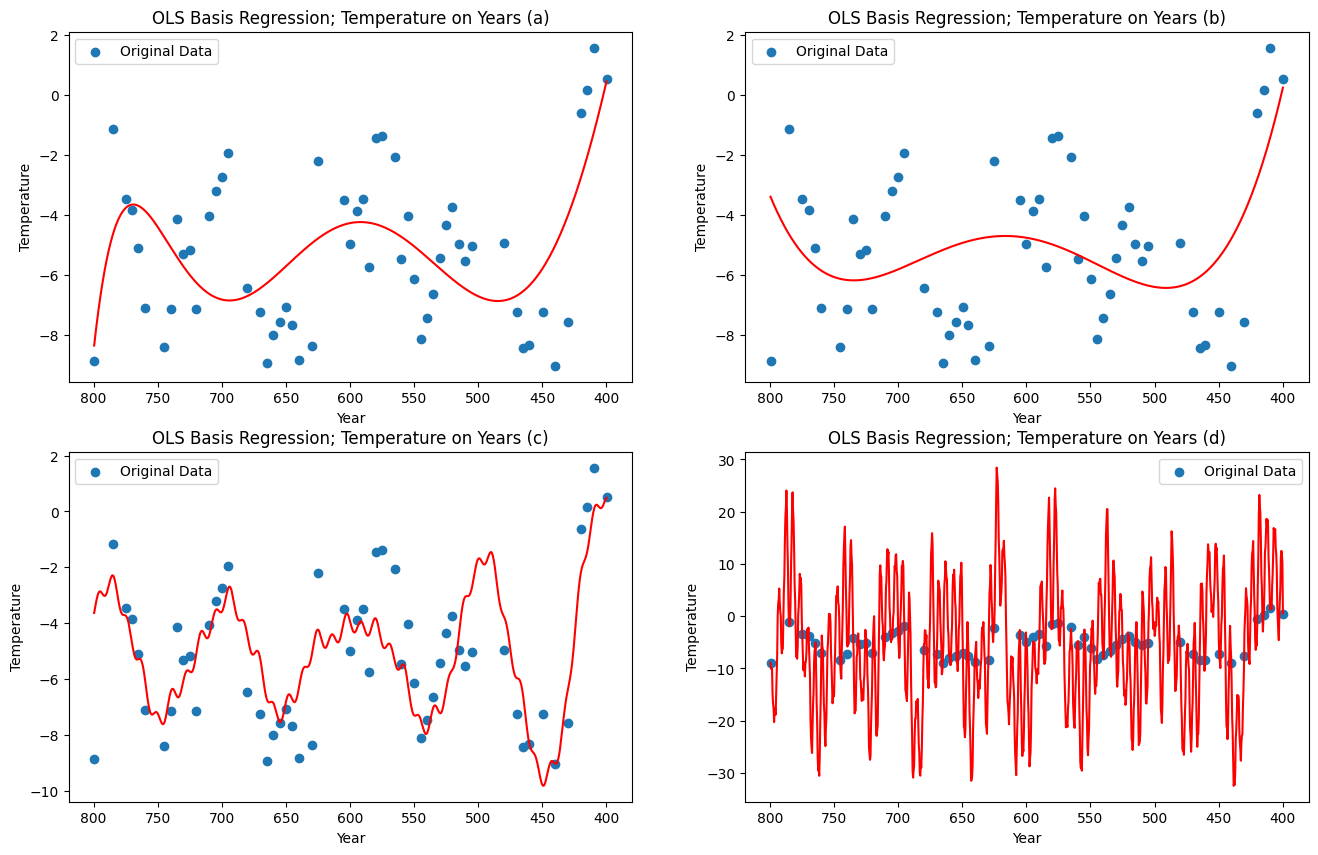

In [18]:
_, ax = plt.subplots(2,2, figsize = (16,10))

for i, part in enumerate(['a', 'b', 'c' ,'d']):
  # Plotting the original data
  phi_years_train = make_basis(year_train, part)
  w = find_weights(phi_years_train, temp_train)

  
  ax[i//2, i%2].scatter(year_train, temp_train, label = "Original Data")
  
  xs = np.linspace(year_train.min(), year_train.max(), 1000)
  ax[i//2, i%2].set_xlabel("Year")
  ax[i//2, i%2].set_ylabel("Temperature")
  ax[i//2, i%2].set_title(f"OLS Basis Regression; Temperature on Years ({part})")

  ax[i//2, i%2].legend()

  # TODO: Plot the regression line generated by your model. 
  phi_xs = make_basis(xs, part)
  ys = phi_xs @ w
  
  ax[i//2, i%2].plot(xs, ys, color='red', label=f"Basis Fit ({part})")
  ax[i//2, i%2].invert_xaxis()
  
plt.savefig("img_output/p3.1.png")

## Problem 3 Subpart 2

In [21]:
def calculate_basis_mse(part, x_train, y_train, x_test, y_test):
    # Generate basis for training data and find optimal weights
    phi_train = make_basis(x_train, part)
    w = find_weights(phi_train, y_train)
    
    # Generate basis for test data
    phi_test = make_basis(x_test, part)
    
    # Predict on test set: y_hat = Phi_test * w
    y_hat_test = phi_test @ w
    
    # Calculate MSE: average of (y_actual - y_pred)^2
    mse = np.mean((y_test - y_hat_test)**2)
    return mse

# Calculate and report for all four parts
for p in ['a', 'b', 'c', 'd']:
    mse_value = calculate_basis_mse(p, year_train, temp_train, year_test, temp_test)
    print(f"MSE for Basis ({p}): {mse_value:.4f}")

MSE for Basis (a): 7.9559
MSE for Basis (b): 8.7081
MSE for Basis (c): 5.9670
MSE for Basis (d): 58.9367


# Problem 4

## Problem 4 Subpart 5

In [ ]:
def find_lasso_weights(lam, X, y):
    """
    Fit the weights of a LASSO linear regression through the coordinate descent algorithm.

    :param lam: the lambda parameter
    :param X: the design matrix with training set features
    :param y: the training set labels
    :return: the fitted weights
    """
    N, D = X.shape
    max_iters = 5000
    # Step (a): Initialize w with a vector of ones
    w = np.ones((D, 1))
    
    # Ensure y is the correct shape (N, 1) to prevent broadcasting issues
    y = y.reshape(-1, 1)
    
    for _ in range(max_iters):
        w_old = w.copy()
        
        # Iterate through each dimension d
        for d in range(D):
            x_d = X[:, d:d+1]  # Shape (N, 1)
            
            # Compute rho_d
            # Prediction using all features except d
            y_pred_minus_d = X @ w - w[d] * x_d
            
            # scalar for rho_d
            rho_d = np.squeeze(x_d.T @ (y - y_pred_minus_d))
            
            # Update weights
            norm_x_d_sq = np.sum(x_d**2)
            
            # Avoid division by zero if a feature has no variance
            if norm_x_d_sq == 0:
                w[d] = 0
                continue

            if d == 0:
                # w_1 (index 0) is not regularized
                w[d] = rho_d / norm_x_d_sq
            else:
                # Soft-thresholding for regularized weights
                # sign(rho) * max(|rho| - lambda/2, 0) / ||x_d||^2
                margin = np.abs(rho_d) - (lam / 2.0)
                w[d] = np.sign(rho_d) * np.maximum(margin, 0) / norm_x_d_sq
        
        # Convergence check
        if np.allclose(w, w_old, atol=1e-6):
            break
            
    return w

In [38]:
# Helper function for standardizing inputs to LASSO
def preprocess_lasso(X):
    X = make_basis(X, part='d')
    X[:, 1:] = (X[:, 1:] - X[:, 1:].mean(axis = 0)) / X[:, 1:].std(axis = 0)
    return X

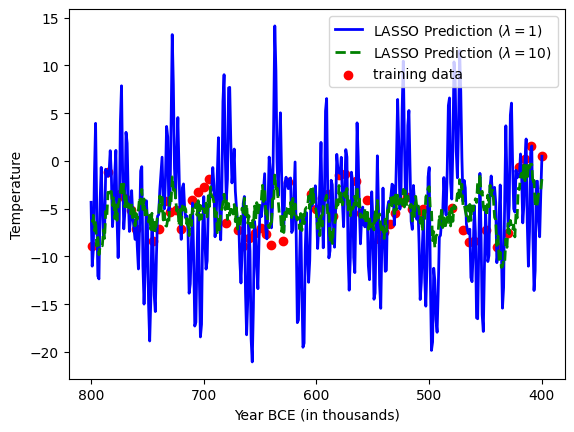

In [39]:
# Fit the weights for both models
phi_x_train = preprocess_lasso(year_train)
lam1, lam2 = 1, 10
w1 = find_lasso_weights(lam1, phi_x_train, temp_train)
w2 = find_lasso_weights(lam2, phi_x_train, temp_train)

# Plot functions
x_array = np.arange(400, 800 + 1, 1)
phi_x_array = preprocess_lasso(x_array)

# Generate predictions for both lambda values
y_pred1 = phi_x_array @ w1
y_pred2 = phi_x_array @ w2

# Plotting
plt.plot(x_array, y_pred1, label=r"LASSO Prediction ($\lambda={}$)".format(lam1), color="blue", linewidth=2)
plt.plot(x_array, y_pred2, label=r"LASSO Prediction ($\lambda={}$)".format(lam2), color="green", linewidth=2, linestyle="--")

plt.scatter(year_train, temp_train, label = "training data", color = "red")
plt.legend()
plt.xticks(np.arange(400, 800 + 100, 100))
plt.ylabel("Temperature")
plt.xlabel("Year BCE (in thousands)")

plt.gca().invert_xaxis()
# save figure to img_output directory
plt.savefig("img_output/p4.5.png", bbox_inches = "tight")
plt.show()

In [42]:
# Preprocess the test data
phi_x_test = preprocess_lasso(year_test)

# Generate predictions for the TEST set
y_test_pred1 = phi_x_test @ w1
y_test_pred2 = phi_x_test @ w2

# Compute TEST MSE
mse_test1 = np.mean((y_test_pred1.flatten() - temp_test.flatten()) ** 2)
mse_test2 = np.mean((y_test_pred2.flatten() - temp_test.flatten()) ** 2)

print(f"Test MSE for lambda={lam1}: {mse_test1}")
print(f"Test MSE for lambda={lam2}: {mse_test2}")

Test MSE for lambda=1: 30.063073126951426
Test MSE for lambda=10: 15.618255854132297
